In [1]:
# Imports & setup
import os, time, random, numpy as np, tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print(tf.__version__)

2.20.0


In [2]:
# Load IMDB dataset
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test  = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

print("Train:", x_train.shape, "Test:", x_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train: (25000, 200) Test: (25000, 200)


In [3]:
# Build a factory to create models with a given recurrent layer type
from tensorflow.keras import layers, models

def make_model(cell_type="SimpleRNN", units=64, bidirectional=True):
    inputs = layers.Input(shape=(maxlen,), dtype='int32')
    x = layers.Embedding(vocab_size, 128, mask_zero=True)(inputs)

    RNNLayer = {
        "SimpleRNN": layers.SimpleRNN,
        "LSTM": layers.LSTM,
        "GRU": layers.GRU,
    }[cell_type]

    rnn = RNNLayer(units, return_sequences=False)
    if bidirectional:
        x = layers.Bidirectional(rnn)(x)
    else:
        x = rnn(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs, name=f"{cell_type}_classifier")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_eval(cell_type):
    model = make_model(cell_type)
    model.summary()
    start = time.time()
    hist = model.fit(x_train, y_train, validation_split=0.2, epochs=3, batch_size=128, verbose=1)
    secs = time.time() - start
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    params = model.count_params()
    return {"model": model, "history": hist.history, "test_acc": test_acc, "test_loss": test_loss, "secs": secs, "params": params}

results = {}
for kind in ["SimpleRNN", "LSTM", "GRU"]:
    print(f"\n=== Training {kind} ===")
    results[kind] = train_and_eval(kind)


=== Training SimpleRNN ===


Model: "SimpleRNN_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 128)          │       2,560,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 200)               │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 128)               │          24,704 │ embedding[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ bidirectional[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              65 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,593,025 (9.89 MB)

 Trainable params: 2,593,025 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5495 - loss: 0.6811 - val_accuracy: 0.6308 - val_loss: 0.6458
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.7565 - loss: 0.5103 - val_accuracy: 0.7764 - val_loss: 0.4825
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9156 - loss: 0.2116 - val_accuracy: 0.8054 - val_loss: 0.5128

=== Training LSTM ===


Model: "LSTM_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 200, 128)          │       2,560,000 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 200)               │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 128)               │          98,816 │ embedding_1[0][0],         │
│ (Bidirectional)               │                           │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ bidirectional_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │           8,256 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │              65 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 518ms/step - accuracy: 0.7707 - loss: 0.4571 - val_accuracy: 0.8678 - val_loss: 0.3204
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 532ms/step - accuracy: 0.9191 - loss: 0.2092 - val_accuracy: 0.8636 - val_loss: 0.3375
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 556ms/step - accuracy: 0.9527 - loss: 0.1345 - val_accuracy: 0.8320 - val_loss: 0.5089

=== Training GRU ===


Model: "GRU_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 200, 128)          │       2,560,000 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_2 (NotEqual)        │ (None, 200)               │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_2               │ (None, 128)               │          74,496 │ embedding_2[0][0],         │
│ (Bidirectional)               │                           │                 │ not_equal_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ bidirectional_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 64)                │           8,256 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │              65 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,642,817 (10.08 MB)

 Trainable params: 2,642,817 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 532ms/step - accuracy: 0.7105 - loss: 0.5284 - val_accuracy: 0.8650 - val_loss: 0.3359
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 565ms/step - accuracy: 0.9046 - loss: 0.2420 - val_accuracy: 0.8500 - val_loss: 0.3507
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 566ms/step - accuracy: 0.9393 - loss: 0.1628 - val_accuracy: 0.8178 - val_loss: 0.5918


In [4]:
# Compare results
import pandas as pd
df = pd.DataFrame({
    "Model": list(results.keys()),
    "Test Accuracy": [results[k]["test_acc"] for k in results],
    "Test Loss": [results[k]["test_loss"] for k in results],
    "Train Time (s)": [results[k]["secs"] for k in results],
    "Params": [results[k]["params"] for k in results],
})
df

,Model,Test Accuracy,Test Loss,Train Time (s),Params
0,SimpleRNN,0.79088,0.538102,63.368323,2593025
1,LSTM,0.81524,0.552519,255.385461,2667137
2,GRU,0.80808,0.606956,263.945616,2642817


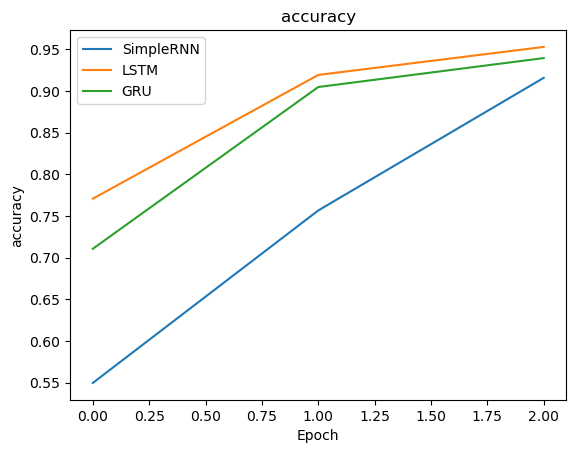

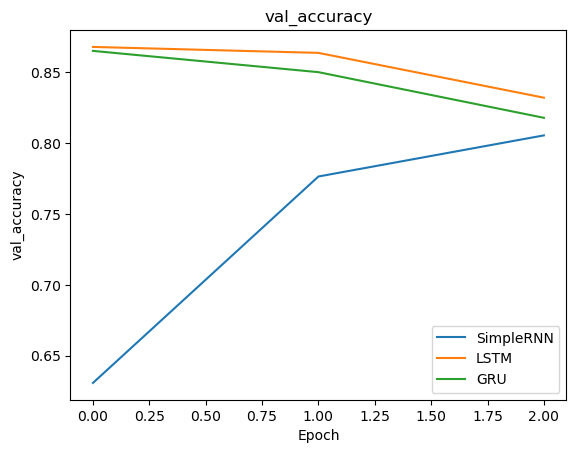

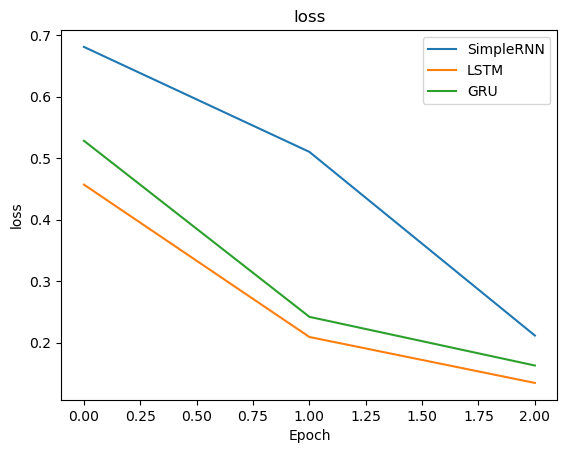

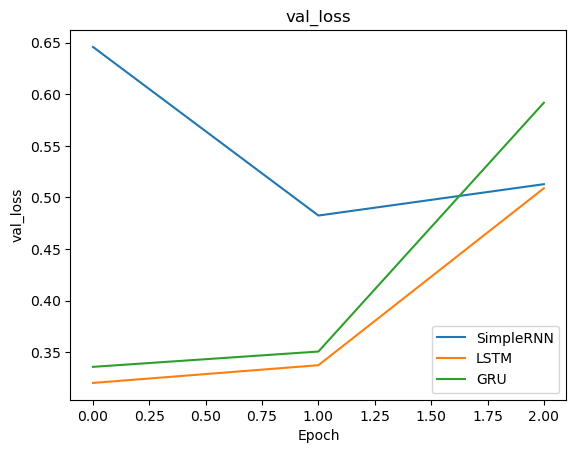

In [5]:
# Plot training curves for each model
import matplotlib.pyplot as plt

for metric in ["accuracy", "val_accuracy", "loss", "val_loss"]:
    plt.figure()
    for k in results:
        plt.plot(results[k]["history"][metric], label=k)
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.show()